<a href="https://colab.research.google.com/github/MaliheDahmardeh/state-house-price-analysis-SM/blob/main/state-house-price-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [301]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil import parser
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats,signal
from scipy.stats import chi2, chi2_contingency
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [302]:
!ls

sample_data  State_house_prices_ts.csv


In [303]:
df = pd.read_csv('State_house_prices_ts.csv', sep =',',parse_dates=['Date']).sort_values(by='Date', ascending=True , inplace=False)

In [304]:
display(df)
display(type(df))
display(df.dtypes)

,Date,RegionName,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
1997,1996-04-30,Illinois,83800.0,92000.0,109300.0,171700.0,224000.0,116000.0
2006,1996-04-30,Michigan,66600.0,76900.0,98200.0,170200.0,166500.0,85400.0
2005,1996-04-30,Massachusetts,82900.0,106600.0,136300.0,195400.0,249200.0,144300.0
2003,1996-04-30,Maine,NaN,79000.0,91500.0,112600.0,135100.0,88300.0
2002,1996-04-30,Louisiana,NaN,NaN,76400.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
12988,2017-12-31,Maryland,160400.0,193400.0,251300.0,378700.0,507700.0,285000.0
12989,2017-12-31,Massachusetts,289300.0,301000.0,368300.0,519100.0,720900.0,392900.0
12990,2017-12-31,Michigan,101700.0,118800.0,158500.0,282900.0,294100.0,134800.0
12992,2017-12-31,Mississippi,NaN,NaN,124100.0,221000.0,250400.0,118500.0


pandas.core.frame.DataFrame

Date                           datetime64[ns]
RegionName                             object
Price_1bedroom                        float64
Price_2bedroom                        float64
Price_3bedroom                        float64
Price_4bedroom                        float64
Price_5BedroomOrMore                  float64
Price_SingleFamilyResidence           float64
dtype: object

In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13212 entries, 1997 to 13006
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         13212 non-null  datetime64[ns]
 1   RegionName                   13212 non-null  object        
 2   Price_1bedroom               10605 non-null  float64       
 3   Price_2bedroom               11745 non-null  float64       
 4   Price_3bedroom               12787 non-null  float64       
 5   Price_4bedroom               12359 non-null  float64       
 6   Price_5BedroomOrMore         11814 non-null  float64       
 7   Price_SingleFamilyResidence  12438 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 929.0+ KB


In [255]:
df.duplicated().sum()  

0

In [256]:
df.isnull().sum()

Date                              0
RegionName                        0
Price_1bedroom                 2607
Price_2bedroom                 1467
Price_3bedroom                  425
Price_4bedroom                  853
Price_5BedroomOrMore           1398
Price_SingleFamilyResidence     774
dtype: int64

In [257]:
#This will keep only rows which have nan's less than 6 in the dataframe, and will remove all having nan's > 6.
df = df[df.isnull().sum(axis=1) < 5]

In [258]:
df2 = df.groupby('RegionName').median()
df2

,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
RegionName,,,,,,
Alabama,88100.0,69700.0,116800.0,218900.0,316200.0,115600.0
Alaska,124550.0,175550.0,251100.0,319600.0,416800.0,254300.0
Arizona,87100.0,133100.0,150800.0,203900.0,315600.0,165300.0
Arkansas,80200.0,81500.0,122500.0,212100.0,323900.0,102400.0
California,219500.0,273000.0,316100.0,415200.0,565900.0,344000.0
Colorado,134300.0,163600.0,210600.0,293000.0,361200.0,222300.0
Connecticut,118800.0,167600.0,231400.0,356200.0,570300.0,253800.0
Delaware,122400.0,144400.0,182600.0,284200.0,343600.0,190800.0
DistrictofColumbia,323200.0,386500.0,353500.0,567300.0,1123400.0,372900.0


In [259]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, Alabama to Wyoming
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price_1bedroom               43 non-null     float64
 1   Price_2bedroom               47 non-null     float64
 2   Price_3bedroom               51 non-null     float64
 3   Price_4bedroom               49 non-null     float64
 4   Price_5BedroomOrMore         48 non-null     float64
 5   Price_SingleFamilyResidence  50 non-null     float64
dtypes: float64(6)
memory usage: 2.8+ KB


In [260]:
df = df.fillna(df2).reset_index()
df.sort_values(by='Date', ascending=True , inplace=False)
df.drop(columns=['index'], inplace=True)
df.head(20)

,Date,RegionName,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
0,1996-04-30,Illinois,83800.0,92000.0,109300.0,171700.0,224000.0,116000.0
1,1996-04-30,Michigan,66600.0,76900.0,98200.0,170200.0,166500.0,85400.0
2,1996-04-30,Massachusetts,82900.0,106600.0,136300.0,195400.0,249200.0,144300.0
3,1996-04-30,Maine,NaN,79000.0,91500.0,112600.0,135100.0,88300.0
4,1996-04-30,Kentucky,49300.0,64600.0,78600.0,126800.0,151100.0,74400.0
5,1996-04-30,Iowa,49600.0,53600.0,66800.0,79900.0,NaN,56300.0
6,1996-04-30,Indiana,47900.0,53500.0,75800.0,NaN,131400.0,71600.0
7,1996-04-30,Idaho,75000.0,81800.0,103300.0,131500.0,161100.0,109600.0
8,1996-04-30,Hawaii,152300.0,186600.0,231800.0,303400.0,345500.0,262600.0
9,1996-04-30,Georgia,74900.0,64700.0,88000.0,149700.0,212800.0,92400.0


In [201]:
#state=df.loc[(df['RegionName']=='Maine')]
#state

In [261]:
df.isnull().sum()

Date                              0
RegionName                        0
Price_1bedroom                 2244
Price_2bedroom                 1104
Price_3bedroom                  246
Price_4bedroom                  490
Price_5BedroomOrMore           1035
Price_SingleFamilyResidence     411
dtype: int64

In [262]:
df.describe()

,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
count,10605.000000,11745.000000,12603.000000,12359.000000,1.181400e+04,12438.000000
mean,117060.424328,135168.803746,168014.234706,243829.670685,3.237335e+05,174154.381733
std,61056.036728,72267.645405,80396.446433,106216.755129,1.702917e+05,92243.367198
min,30900.000000,32800.000000,49600.000000,64700.000000,6.860000e+04,37900.000000
25%,74600.000000,86700.000000,117400.000000,174900.000000,2.179000e+05,115000.000000
50%,100400.000000,115400.000000,142000.000000,218000.000000,2.880000e+05,147300.000000
75%,142300.000000,166800.000000,205300.000000,281000.000000,3.653000e+05,211775.000000
max,390200.000000,542400.000000,639700.000000,850400.000000,1.497000e+06,737500.000000


In [263]:
print('columns:', df.columns)
print('')
print('indexes:', df.index)
print('')
print('values:', df.values)

columns: Index(['Date', 'RegionName', 'Price_1bedroom', 'Price_2bedroom',
       'Price_3bedroom', 'Price_4bedroom', 'Price_5BedroomOrMore',
       'Price_SingleFamilyResidence'],
      dtype='object')

indexes: RangeIndex(start=0, stop=12849, step=1)

values: [[Timestamp('1996-04-30 00:00:00') 'Illinois' 83800.0 ... 171700.0
  224000.0 116000.0]
 [Timestamp('1996-04-30 00:00:00') 'Michigan' 66600.0 ... 170200.0
  166500.0 85400.0]
 [Timestamp('1996-04-30 00:00:00') 'Massachusetts' 82900.0 ... 195400.0
  249200.0 144300.0]
 ...
 [Timestamp('2017-12-31 00:00:00') 'Michigan' 101700.0 ... 282900.0
  294100.0 134800.0]
 [Timestamp('2017-12-31 00:00:00') 'Mississippi' nan ... 221000.0
  250400.0 118500.0]
 [Timestamp('2017-12-31 00:00:00') 'Pennsylvania' 118800.0 ... 292100.0
  307000.0 168100.0]]


#Data manipulation

In [313]:
df['houseprice'] = df['Price_1bedroom']+df['Price_2bedroom']+df['Price_3bedroom']+df['Price_4bedroom']+df['Price_5BedroomOrMore']+df['Price_SingleFamilyResidence']
house_price_by_region= pd.pivot_table(data=df, index='Date', columns='RegionName',values='houseprice')

In [265]:
display(house_price_by_region)
display(type(house_price_by_region))
display(house_price_by_region.dtypes)
display(house_price_by_region.index)

RegionName,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,DistrictofColumbia,Florida,...,Oklahoma,Oregon,Pennsylvania,RhodeIsland,SouthDakota,Tennessee,Vermont,Virginia,Washington,Wisconsin
Date,,,,,,,,,,,,,,,,,,,,,
1996-04-30,620400.0,NaN,668100.0,569900.0,991400.0,826900.0,927700.0,723100.0,NaN,625500.0,...,418400.0,773600.0,604800.0,758500.0,NaN,593200.0,NaN,766000.0,837300.0,NaN
1996-05-31,614900.0,NaN,668100.0,570700.0,988900.0,828800.0,926000.0,724200.0,NaN,626400.0,...,418000.0,776500.0,603900.0,755900.0,524300.0,595100.0,NaN,766400.0,837200.0,NaN
1996-06-30,613100.0,NaN,669200.0,572600.0,984400.0,829600.0,926300.0,725800.0,NaN,625600.0,...,416900.0,779400.0,603300.0,753000.0,522200.0,597400.0,NaN,765600.0,836900.0,NaN
1996-07-31,612600.0,NaN,670000.0,572900.0,980700.0,830400.0,927200.0,726400.0,NaN,624300.0,...,416300.0,782400.0,602300.0,749500.0,520000.0,599400.0,NaN,764500.0,837100.0,NaN
1996-08-31,611800.0,NaN,670900.0,573100.0,977800.0,831300.0,926400.0,726800.0,NaN,623800.0,...,416200.0,785400.0,602000.0,746200.0,519600.0,601600.0,NaN,764100.0,837400.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,1007300.0,1704700.0,1446500.0,1050700.0,3170600.0,2119200.0,1725200.0,1436800.0,4395600.0,1482200.0,...,837800.0,1995800.0,1162400.0,1778600.0,1091100.0,1203700.0,1573200.0,1723900.0,2240900.0,1053200.0
2017-09-30,1011800.0,1705200.0,1455300.0,1055200.0,3188700.0,2129000.0,1731800.0,1443700.0,4399600.0,1490900.0,...,839800.0,2005500.0,1167900.0,1792400.0,1098300.0,1211500.0,1576300.0,1728900.0,2259300.0,1058900.0
2017-10-31,1013700.0,1707600.0,1465100.0,1059300.0,3209600.0,2139900.0,1736500.0,1455900.0,4398100.0,1499300.0,...,841700.0,2012300.0,1173500.0,1807000.0,1103900.0,1218800.0,1569600.0,1732100.0,2278900.0,1063400.0


pandas.core.frame.DataFrame

RegionName
Alabama               float64
Alaska                float64
Arizona               float64
Arkansas              float64
California            float64
Colorado              float64
Connecticut           float64
Delaware              float64
DistrictofColumbia    float64
Florida               float64
Georgia               float64
Hawaii                float64
Idaho                 float64
Illinois              float64
Indiana               float64
Iowa                  float64
Kentucky              float64
Maine                 float64
Maryland              float64
Massachusetts         float64
Michigan              float64
Minnesota             float64
Missouri              float64
Montana               float64
Nebraska              float64
NewHampshire          float64
NewJersey             float64
NewYork               float64
NorthCarolina         float64
Ohio                  float64
Oklahoma              float64
Oregon                float64
Pennsylvania          float64

DatetimeIndex(['1996-04-30', '1996-05-31', '1996-06-30', '1996-07-31',
               '1996-08-31', '1996-09-30', '1996-10-31', '1996-11-30',
               '1996-12-31', '1997-01-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=261, freq=None)

In [316]:
# Converting the index as date with monthly frequency
house_price_by_region.index = pd.to_datetime(house_price_by_region.index)
house_price_by_region= house_price_by_region.asfreq('M')
display(house_price_by_region.index)
display(house_price_by_region)

DatetimeIndex(['1996-04-30', '1996-05-31', '1996-06-30', '1996-07-31',
               '1996-08-31', '1996-09-30', '1996-10-31', '1996-11-30',
               '1996-12-31', '1997-01-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=261, freq='M')

RegionName,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,DistrictofColumbia,Florida,...,Oklahoma,Oregon,Pennsylvania,RhodeIsland,SouthDakota,Tennessee,Vermont,Virginia,Washington,Wisconsin
Date,,,,,,,,,,,,,,,,,,,,,
1996-04-30,620400.0,NaN,668100.0,569900.0,991400.0,826900.0,927700.0,723100.0,NaN,625500.0,...,418400.0,773600.0,604800.0,758500.0,NaN,593200.0,NaN,766000.0,837300.0,NaN
1996-05-31,614900.0,NaN,668100.0,570700.0,988900.0,828800.0,926000.0,724200.0,NaN,626400.0,...,418000.0,776500.0,603900.0,755900.0,524300.0,595100.0,NaN,766400.0,837200.0,NaN
1996-06-30,613100.0,NaN,669200.0,572600.0,984400.0,829600.0,926300.0,725800.0,NaN,625600.0,...,416900.0,779400.0,603300.0,753000.0,522200.0,597400.0,NaN,765600.0,836900.0,NaN
1996-07-31,612600.0,NaN,670000.0,572900.0,980700.0,830400.0,927200.0,726400.0,NaN,624300.0,...,416300.0,782400.0,602300.0,749500.0,520000.0,599400.0,NaN,764500.0,837100.0,NaN
1996-08-31,611800.0,NaN,670900.0,573100.0,977800.0,831300.0,926400.0,726800.0,NaN,623800.0,...,416200.0,785400.0,602000.0,746200.0,519600.0,601600.0,NaN,764100.0,837400.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,1007300.0,1704700.0,1446500.0,1050700.0,3170600.0,2119200.0,1725200.0,1436800.0,4395600.0,1482200.0,...,837800.0,1995800.0,1162400.0,1778600.0,1091100.0,1203700.0,1573200.0,1723900.0,2240900.0,1053200.0
2017-09-30,1011800.0,1705200.0,1455300.0,1055200.0,3188700.0,2129000.0,1731800.0,1443700.0,4399600.0,1490900.0,...,839800.0,2005500.0,1167900.0,1792400.0,1098300.0,1211500.0,1576300.0,1728900.0,2259300.0,1058900.0
2017-10-31,1013700.0,1707600.0,1465100.0,1059300.0,3209600.0,2139900.0,1736500.0,1455900.0,4398100.0,1499300.0,...,841700.0,2012300.0,1173500.0,1807000.0,1103900.0,1218800.0,1569600.0,1732100.0,2278900.0,1063400.0


#Functions(plot)

In [268]:
def compute_loess_span(x_input,y_input, steps=0.02):
    import numpy as np
    from statsmodels.nonparametric.smoothers_lowess import lowess

    best_span = 0.51
    lowest_SSE = 10e20
    
    for i in np.arange(1,51,steps*100)/100:
        span=i
        y_pred = lowess(y_input,x_input, frac=span, it=5, return_sorted = False).T
        SSE = ((y_input-y_pred)**2).sum()
        if SSE<lowest_SSE:
            best_span = i
            lowest_SSE = SSE
    return (best_span,lowest_SSE)

In [269]:
def plotTS(df, column, loess=True, regression=True, figsize=(16,4), title='', xlabel='', ylabel='', theme = 'darkgrid', points_alpha = 0.6, custom_ylim=None):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    from statsmodels.nonparametric.smoothers_lowess import lowess


    sns.set_style(theme)
    plt.figure(figsize=figsize)
    plt.scatter(x = df.index, y = df[column], marker='+', alpha=points_alpha, label='Data points')
    
    if loess==True:
        # model fitting
        span, sse = compute_loess_span(df.index,df[column])
        y_loess = lowess(df[column], df.index,  frac=span, it=5, return_sorted = False).T
        #plot
        plt.plot(df.index, y_loess, color='tomato', linewidth=2, label='LOESS (span={})'.format(span))
    if regression==True:
        # model fitting
        model = LinearRegression()
        x_regr = np.arange(len(df[column])).reshape(-1,1)
        model.fit(x_regr,df[column])
        coeff = model.coef_[0]
        y_predicted = model.predict(x_regr)
        #plot
        plt.plot(df.index, y_predicted, color='green', label='Regression line (coeff={})'.format(round(coeff,2)))
    if custom_ylim != None:
        plt.ylim(custom_ylim[0], custom_ylim[1])
    plt.xlim(df.index[0],df.index[-1])
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [270]:
def scalelocationPlot(resid, title='', figsize=(16,8)):
    import pandas as pd
    import statsmodels.formula.api as smf
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    #lm
    resid = pd.DataFrame(resid, columns=['resid'])
    resid['step'] = range(len(resid))
    fit = smf.ols('resid ~ step', data=resid).fit()
    
    #get values
    model_fitted_y = fit.fittedvalues
    model_residuals = fit.resid
    model_norm_residuals = fit.get_influence().resid_studentized_internal
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    
    #plot
    fig = plt.figure(3)
    fig.set_figheight(figsize[1])
    fig.set_figwidth(figsize[0])
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
    sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, scatter=False, ci=False, lowess=True,line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})
    fig.axes[0].set_title('Scale-Location'.format(title), fontsize=14)
    fig.axes[0].set_xlabel('Fitted values')
    fig.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$')
    plt.show()

In [271]:
def autocorrelationPlot(data, lags=30, title=''):
    from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
    import matplotlib.pyplot as plt
    
    fig = plot_acf(data, lags=lags, title='Auto-correlation for the first {} lags {}'.format(lags, title));
    fig.set_figwidth(16)
    fig.set_figheight(6)
    fig = plot_pacf(data, lags=lags, title='Partial Auto-correlation for the first {} lags {}'.format(lags, title));
    fig.set_figwidth(16)
    fig.set_figheight(6)
    plt.show()

In [272]:
def qqPlot(data, title=''):
    fig = sm.qqplot(data, line ='45',fit=True,dist=stats.norm)
    fig.set_figheight(8)
    fig.set_figwidth(8)
    plt.title('Q-Q {}'.format(title))
    plt.show()

#Data exploration

#How is the tren of price of houses in the united states during the years:

In [273]:
price_total = house_price_by_region.sum(axis=1)
price_total_by_year = price_total.resample('Y').sum()
price_total_by_year.index = price_total_by_year.index.year
price_total_by_year = price_total_by_year/1000000
display(price_total_by_year)

Date
1996    200.3525
1997    278.6697
1998    310.6717
1999    342.7902
2000    375.7326
2001    410.1433
2002    460.4511
2003    509.9731
2004    575.3660
2005    648.7311
2006    693.7868
2007    699.3403
2008    673.4159
2009    630.7748
2010    609.3321
2011    590.4400
2012    588.3798
2013    617.9343
2014    647.8473
2015    676.1126
2016    710.1863
2017    749.5959
dtype: float64

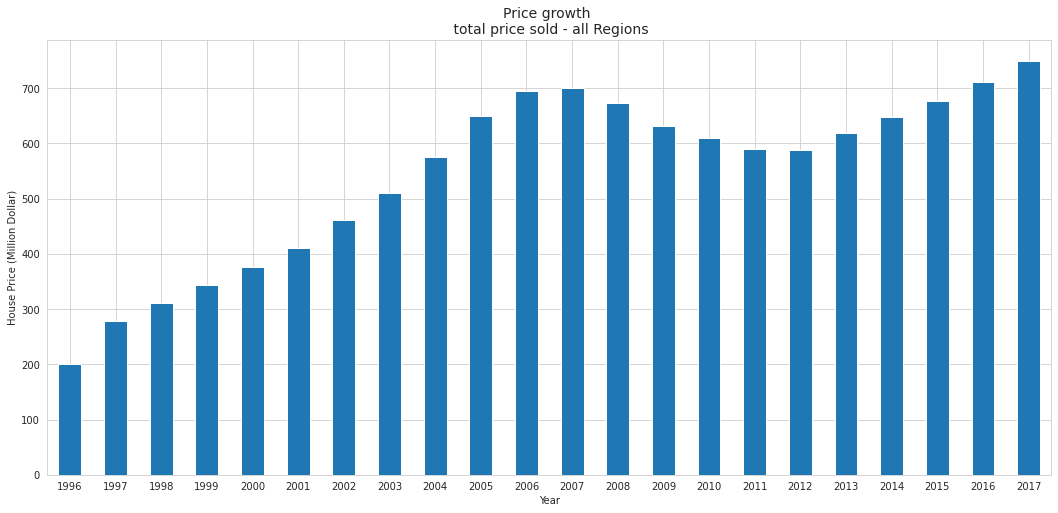

In [274]:
plt.figure(figsize=(18,8))
sns.set_style('whitegrid')
price_total_by_year.plot(kind='bar', rot=0, ylabel='House Price (Million Dollar)', xlabel='Year')
plt.title('Price growth \n total price sold - all Regions', fontsize=14)
plt.show()

#In what States the house price is more expensive:

In [275]:
price_total_by_Region = house_price_by_region.sum(axis=0)
price_total_by_regions  = pd.Series(price_total_by_Region , name='RegionName')
price_total_by_regions = price_total_by_Region.sort_values(ascending=False).head(10)

display(price_total_by_regions)

RegionName
Hawaii                671738100.0
DistrictofColumbia    664954600.0
California            567633000.0
Massachusetts         493029300.0
NewJersey             431455000.0
Connecticut           418604300.0
Washington            385042700.0
Maryland              382427500.0
RhodeIsland           372439900.0
Virginia              363337400.0
dtype: float64

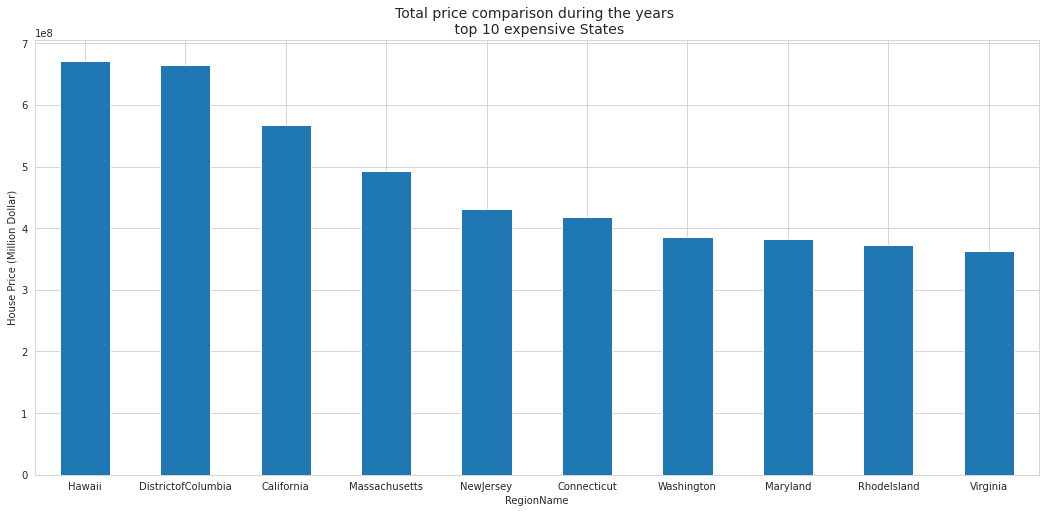

In [279]:
plt.figure(figsize=(18,8))
sns.set_style('whitegrid')
price_total_by_regions.plot(kind='bar', rot=0, ylabel='House Price (Million Dollar)', xlabel='RegionName')
plt.title('Total price comparison during the years \n top 10 expensive States', fontsize=14)
plt.show()

In [277]:
df3 = df.groupby('RegionName').sum()['houseprice']
df3

RegionName
Alabama               228393400.0
Alaska                342865700.0
Arizona               291403200.0
Arkansas              221877500.0
California            567633000.0
Colorado              358761100.0
Connecticut           418604300.0
Delaware              308451500.0
DistrictofColumbia    664954600.0
Florida               289925900.0
Georgia               255330500.0
Hawaii                671738100.0
Idaho                 234455700.0
Illinois              295562800.0
Indiana               143471500.0
Iowa                   73525500.0
Kansas                        0.0
Kentucky              207466000.0
Louisiana                     0.0
Maine                 252230500.0
Maryland              382427500.0
Massachusetts         493029300.0
Michigan              228983200.0
Minnesota             286287400.0
Mississippi                   0.0
Missouri              240418200.0
Montana               226312500.0
Nebraska              194147000.0
Nevada                        0.0
New

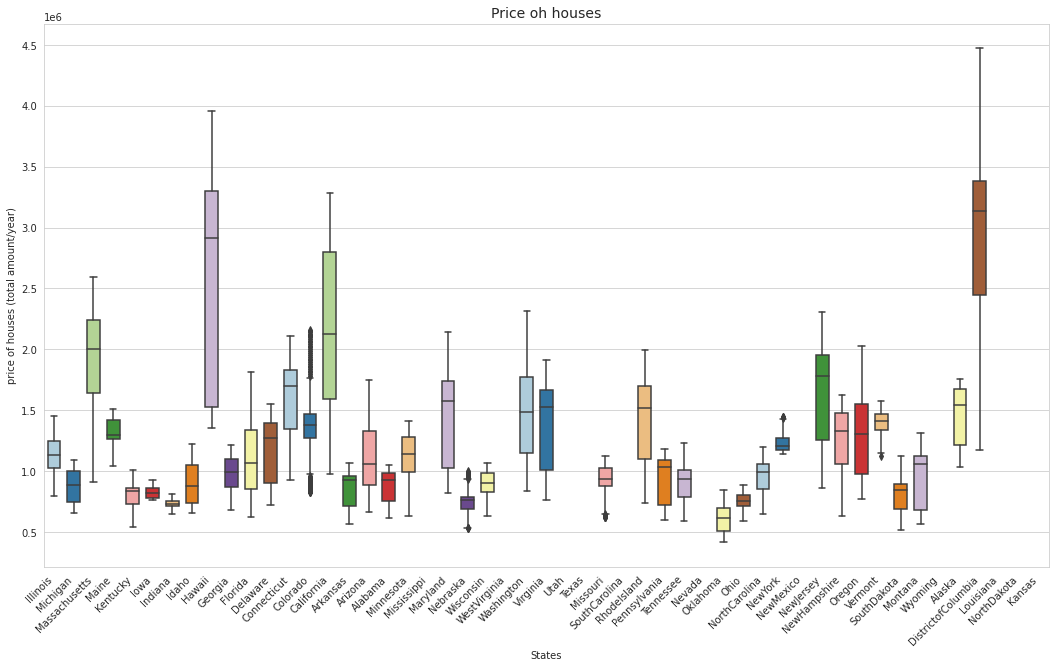

In [280]:

fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot()
sns.set_style('whitegrid')
sns.boxplot(x="RegionName", y="houseprice", data=df, palette='Paired', width=0.65)
plt.title('Price oh houses', fontsize=14)
plt.xlabel('States')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.ylabel('price of houses (total amount/year)')
plt.show()

In [323]:
price_groupby = df[['Date','RegionName','houseprice']].groupby(['Date','RegionName']).sum()
price_groupby['year'] = (price_groupby.index).to_series().map(lambda x : x[0].year)
#rice_groupby['weekday'] = (price_groupby.index).to_series().map(lambda x : x[0].isoweekday())
price_groupby['month'] = (price_groupby.index).to_series().map(lambda x : x[0].month)
display(price_groupby)

houseprice  year  month
Date       RegionName                           
1996-04-30 Alabama         620400.0  1996      4
           Arizona         668100.0  1996      4
           Arkansas        569900.0  1996      4
           California      991400.0  1996      4
           Colorado        826900.0  1996      4
...                             ...   ...    ...
2017-12-31 Virginia       1729000.0  2017     12
           Washington     2311900.0  2017     12
           WestVirginia         0.0  2017     12
           Wisconsin      1069900.0  2017     12
           Wyoming              0.0  2017     12

[13212 rows x 3 columns]

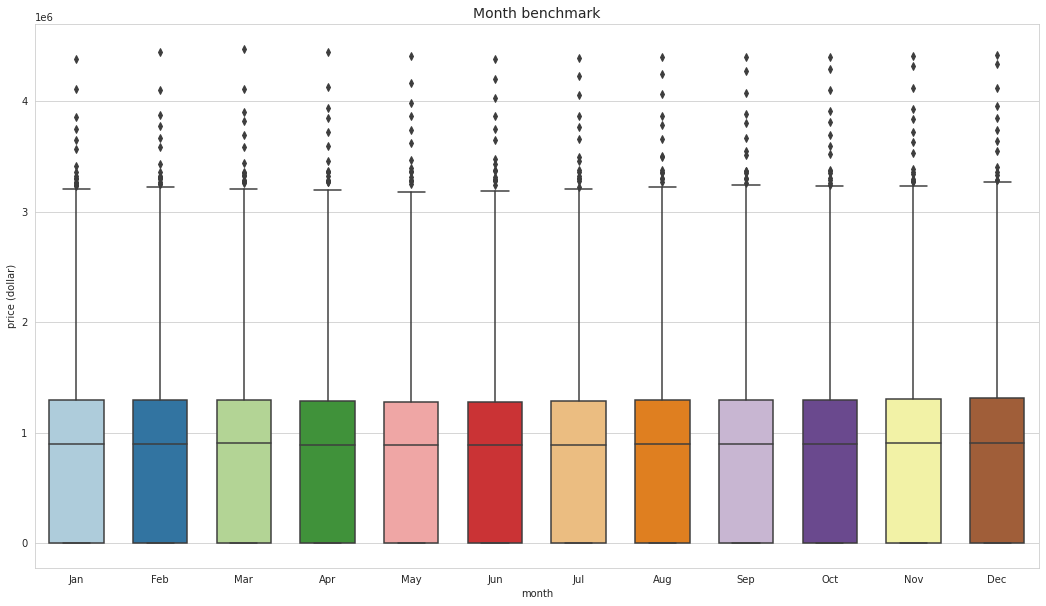

In [325]:
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot()
sns.set_style('whitegrid')
sns.boxplot(data=price_groupby, x='month', y='houseprice', palette='Paired', width=0.65)
plt.title('Month benchmark', fontsize=14)
plt.ylabel('price (dollar)')
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.show()

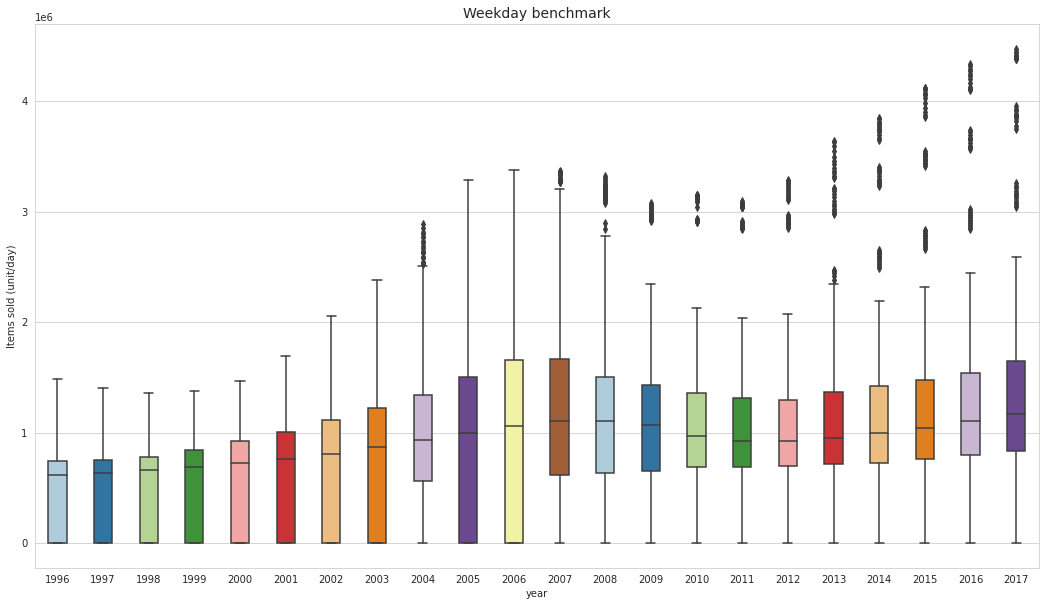

In [333]:
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot()
sns.set_style('whitegrid')
sns.boxplot(data=price_groupby, x='year', y='houseprice', palette='Paired', width=0.4)
plt.title('Weekday benchmark', fontsize=14)
plt.ylabel('Items sold (unit/day)')
ax.set_xticklabels('{}'.format(i) for i in range(1996,2018))
plt.show()

#Discriptive Statistics-Time series Analysis

In [283]:
descriptive_stat = house_price_by_region.describe().T

Q1 = house_price_by_region.quantile(0.25)
Q3 = house_price_by_region.quantile(0.75)
IQR = Q3 - Q1

outlier_lower_count = (house_price_by_region < (Q1 - 1.5 * IQR)).sum()
outlier_upper_count = (house_price_by_region > (Q3 + 1.5 * IQR)).sum()
outlier_total_count = outlier_lower_count + outlier_upper_count

descriptive_stat['range']=descriptive_stat['max']-descriptive_stat['min']
descriptive_stat['IQR']=descriptive_stat['75%']-descriptive_stat['25%']
descriptive_stat['outlier_lower_count'] = outlier_lower_count
descriptive_stat['outlier_upper_count'] = outlier_upper_count
descriptive_stat['outlier_total_count'] = outlier_total_count

display(round(descriptive_stat,2))

,count,mean,std,min,25%,50%,75%,max,range,IQR,outlier_lower_count,outlier_upper_count,outlier_total_count
RegionName,,,,,,,,,,,,,
Alabama,261.0,875070.50,135617.28,611800.0,757600.0,926400.0,988400.0,1051900.0,440100.0,230800.0,0,0,0
Alaska,234.0,1465238.03,242297.07,1036800.0,1215950.0,1542150.0,1674750.0,1752900.0,716100.0,458800.0,0,0,0
Arizona,261.0,1116487.36,302705.38,668100.0,883700.0,1056600.0,1328800.0,1748900.0,1080800.0,445100.0,0,0,0
Arkansas,261.0,850105.36,145051.02,569900.0,714100.0,923700.0,963000.0,1063800.0,493900.0,248900.0,0,0,0
California,261.0,2174839.08,718250.34,976200.0,1593500.0,2130200.0,2801600.0,3280900.0,2304700.0,1208100.0,0,0,0
Colorado,261.0,1374563.60,301618.45,826900.0,1268400.0,1377000.0,1466700.0,2158900.0,1332000.0,198300.0,35,29,64
Connecticut,261.0,1603847.89,353687.60,924900.0,1343000.0,1699200.0,1834300.0,2106000.0,1181100.0,491300.0,0,0,0
Delaware,261.0,1181806.51,269770.23,723100.0,906200.0,1268900.0,1394200.0,1554000.0,830900.0,488000.0,0,0,0
DistrictofColumbia,223.0,2981859.19,879975.88,1174200.0,2443550.0,3134200.0,3381750.0,4472600.0,3298400.0,938200.0,0,0,0


In [310]:
Hawaii_ts = pd.DataFrame(house_price_by_region['Hawaii'])

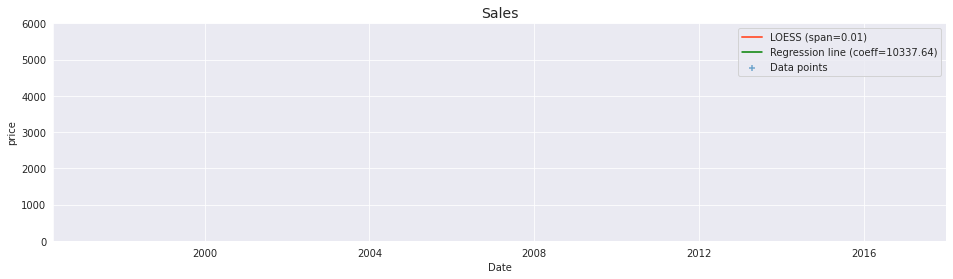

In [311]:
plotTS(Hawaii_ts, column='Hawaii', custom_ylim=(0,6000), title='Sales', xlabel='Date', ylabel='price')

In [294]:
Alabama_ts = pd.DataFrame(house_price_by_region['Alabama'])

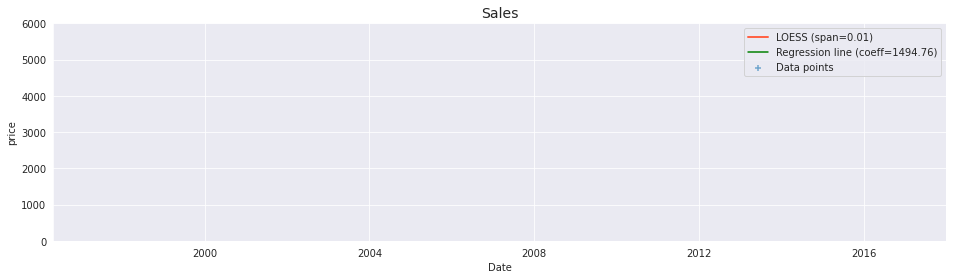

In [295]:
plotTS(Alabama_ts, column='Alabama', custom_ylim=(0,6000), title='Sales', xlabel='Date', ylabel='price')

#Analysis of State,Hawaii

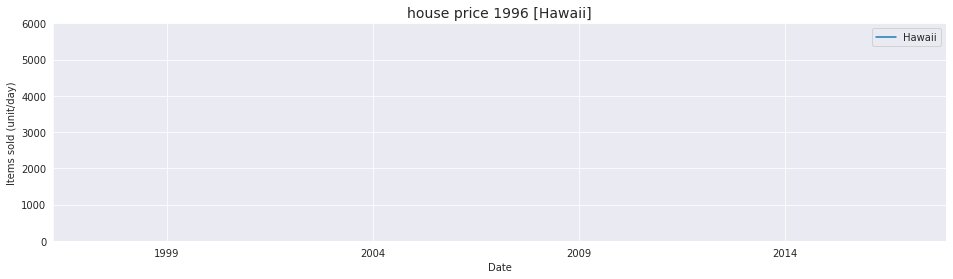

In [308]:
fig = Hawaii_ts.plot(figsize=(16,4), title='house price 1996 [Hawaii]')
fig.axes.title.set_size(14)
plt.xlabel('Date')
plt.ylabel('Items sold (unit/day)')
plt.ylim(0,6000)
plt.show()

#Stationarity

In [297]:
def checkStationarity(data, kpss_type = 'ct', return_data=False, ci=.95):
    alpha = 1-ci
    
    if kpss_type in ['c','ct']:
        import warnings
        warnings.filterwarnings('ignore')
        from statsmodels.tsa.stattools import adfuller
        from statsmodels.tsa.stattools import kpss

        adf_test = adfuller(data,autolag='AIC')
        print('*** ADF Test ***')
        print('ADF Statistic: ', adf_test[0])
        print('p-value: ', adf_test[1])
        if adf_test[1] > alpha:
            print('Interpretation: The time series is non-stationary (Ho)')
        else:
            print('Interpretation: The time series is stationary (Ha)')

        kpss_test = kpss(data, regression=kpss_type, store=True)
        print('\n*** KPSS Test ***')
        print('KPSS Statistic:', kpss_test[0])
        print('p-value: ', kpss_test[1])

        if kpss_type == 'c':
            if kpss_test[1] > alpha:
                print('Interpretation: The time series is stationary (Ho)')
            else:
                print('Interpretation: The time series is not stationary (Ha)')
        if kpss_type == 'ct':
            if kpss_test[1] > alpha:
                print('Interpretation: The time series is trend stationary (Ho)')
            else:
                print('Interpretation: The time series is not trend stationary (Ha)')
    else:
        print('KPSS type shuld be c or ct!')
        print('c: checks if time series is stationary \nct: checks if time series is trend stationary')
    
    if return_data==True:
        return (adf_test[0],adf_test[1],kpss_test[0],kpss_test[1])

In [298]:
checkStationarity(Hawaii_ts['Hawaii'], kpss_type='c')

*** ADF Test ***
ADF Statistic:  -0.9812680163361206
p-value:  0.7600349062134676
Interpretation: The time series is non-stationary (Ho)

*** KPSS Test ***
KPSS Statistic: 1.3861937312012766
p-value:  0.01
Interpretation: The time series is not stationary (Ha)


In [299]:
checkStationarity(Hawaii_ts['Hawaii'], kpss_type='ct')

*** ADF Test ***
ADF Statistic:  -0.9812680163361206
p-value:  0.7600349062134676
Interpretation: The time series is non-stationary (Ho)

*** KPSS Test ***
KPSS Statistic: 0.19044060424763584
p-value:  0.019584773407136557
Interpretation: The time series is not trend stationary (Ha)
